# Searching in a transformed space

In the previous part of the tutorial we set up boundaries and created a method to sample from within those boundaries.
When doing this, we found it useful to replace some parameter values with their logarithm.
In this part of the tutorial we extend this log-transformation approach to the optimisation routine, so that we search in a (partly) log-transformed space.

## Why transform the search space?

Before performing parameter estimation it _can_ be a good idea to perform some kind of transformations on the search space.
For example, some optimisation methods don't perform well on spaces where the error measure varies very rapidly in one direction, but slowly in another.
In these cases it might help to rescale the parameters, e.g. so that they are all restricted to the interval $[0, 1]$.


For the "a-type" parameters in the model used in this tutorial, [Beattie et al.](https://doi.org/10.1113/JP275733) found the prior expectation was for them to vary over many orders of magnitude.
As a result, it seemed sensible to use a log-transformation on these parameters when searching, which led to notably improved results.
Further experimental confirmation of this result was provided in the supplemental results to ["Four Ways to Fit an Ion Channel Model"](https://doi.org/10.1016/j.bpj.2019.08.001), section S2.4.2.

While there is no catch-all strategy that we know of, it may be a good idea to try several transformations when dealing with a difficult parameter estimation problem.
The following section will show how.

## Implementing transformations with wrappers

In this section, we'll set up a synthetic data problem with a forward model and boundaries, and then use _wrappers_ around both to perform the log transformations.

First, we create a class that can transform points from the "model space" to the "search space" and vice versa.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import myokit
import pints

In [3]:
class LogTransform(object):
    """
    Performs forward and backward transformations on the 
    alpha-parameters used in the Beattie et al. model.    
    """
    
    def to_search(self, x):
        """Transforms from model to search space."""
        q = np.copy(x)
        q[0] = np.log(x[0])
        q[2] = np.log(x[2])
        q[4] = np.log(x[4])
        q[6] = np.log(x[6])
        return q

    def to_model(self, q):
        """Transforms from search to model space."""
        x = np.copy(q)
        x[0] = np.exp(q[0])
        x[2] = np.exp(q[2])
        x[4] = np.exp(q[4])
        x[6] = np.exp(q[6])
        return x        

Next, we define a wrapper around the forward model class and around the boundaries class.

In [4]:
class TransformedForwardModel(pints.ForwardModel):
    """
    Wraps around a ``pints.ForwardModel`` and applies parameter 
    transformations.
    """
    
    def __init__(self, model, transform):
        self._model = model
        self._transform = transform
    
    def n_parameters(self):
        return self._model.n_parameters()
    
    def simulate(self, search_parameters, times):
        model_parameters = self._transform.to_model(search_parameters)
        return self._model.simulate(model_parameters, times)

    
class TransformedBoundaries(pints.Boundaries):
    """
    Wraps around a ``pints.Boundaries`` object and applies parameter
    transformations.
    """
    def __init__(self, boundaries, transform):
        self._boundaries = boundaries
        self._transform = transform
    
    def check(self, search_parameters):
        model_parameters = self._transform.to_model(search_parameters)
        return self._boundaries.check(model_parameters)
    
    def n_parameters(self):
        return self._boundaries.n_parameters()
    
    def sample(self, n):
        model_parameters = self._boundaries.sample(n)
        search_parameters = np.zeros(model_parameters.shape)
        for i, p in enumerate(model_parameters):
            search_parameters[i] = self._transform.to_search(model_parameters)
        return search_parameters


Next, we set up an optimisation problem:

In [9]:
# Load a protocol and create a foward model instance
from library import ModelHHSolver as Model
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

# Set up a synthetic data problem and error
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.015, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Create boundaries and take a random sample as initial starting point
from library import Boundaries
boundaries = Boundaries()

# Make a random guess for the parameters
x0 = boundaries.sample(1)[0]

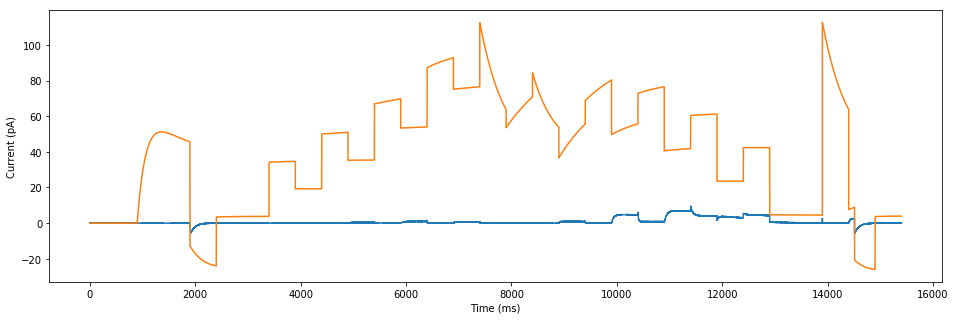

In [10]:
# Visualise the data and starting point
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.show()
plt.show()

To check if it's working, we can run an evaluation with x0 and its transformed counterpart:

In [11]:
# Create the transformation object
transform = LogTransform()

# Create a transformed model and transformed boundaries
transformed_model = TransformedForwardModel(model, transform)
transformed_boundaries = TransformedBoundaries(boundaries, transform)

# Set up a problem with the transformed model
transformed_problem = pints.SingleOutputProblem(transformed_model, times, values)
transformed_error = pints.MeanSquaredError(transformed_problem)

# Create a transformed starting point
q0 = transform.to_search(x0)

print('Untransformed:')
print(x0)
print('Transformed:')
print(q0)


Untransformed:
[4.32014002e-04 5.11328805e-02 1.37751373e-06 4.40236812e-02
 2.35332782e-07 2.20487070e-01 1.09401923e-03 7.59426545e-03
 9.63779037e-01]
Transformed:
[-7.74705256e+00  5.11328805e-02 -1.34952303e+01  4.40236812e-02
 -1.52622652e+01  2.20487070e-01 -6.81789700e+00  7.59426545e-03
  9.63779037e-01]


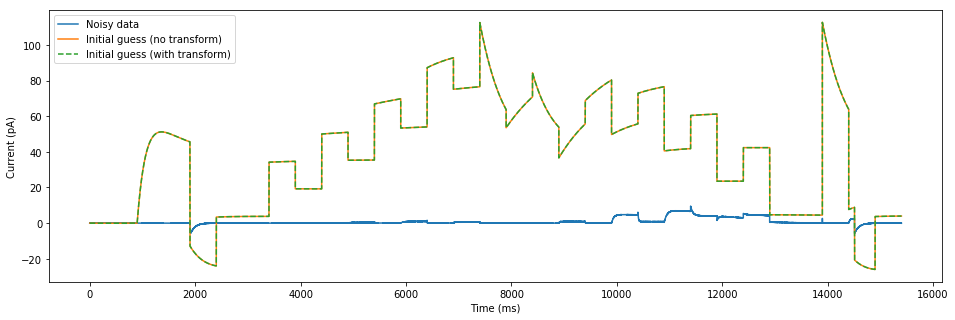

In [12]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), 
         label='Initial guess (no transform)')
plt.plot(times, transformed_problem.evaluate(q0), '--',
         label='Initial guess (with transform)')
plt.legend()
plt.show()

Now lets run an optimisation, without using log transforms:

In [13]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries)
opt.set_parallel(True)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     2202.075   0:00.3
1     20     1918.12    0:00.4
2     30     1785.407   0:00.6
3     40     1671.771   0:00.8
20    210    627.4384   0:03.6
40    410    21.85133   0:06.8
60    552    2.940596   0:09.3
80    699    1.378025   0:11.8
100   829    1.372262   0:14.2
120   984    1.372262   0:17.1
140   1170   1.372262   0:20.1
160   1370   1.372262   0:23.6
180   1570   1.360254   0:26.7
200   1764   1.329295   0:29.8
220   1930   1.319826   0:32.4
240   2099   1.312814   0:35.4
260   2264   1.304197   0:38.1
280   2450   1.288148   0:41.3
300   2628   1.272265   0:44.2
320   2791   1.244433   0:47.1
340   2978   0.956653   0:52.2
360   3166   0.796      0:56.6
380   3357   0.647      1:00.1
400   3548   0.494      1:03.6
420   3736   0.452      1:07.5
440   3922   0.38       1:10.7
460   4080

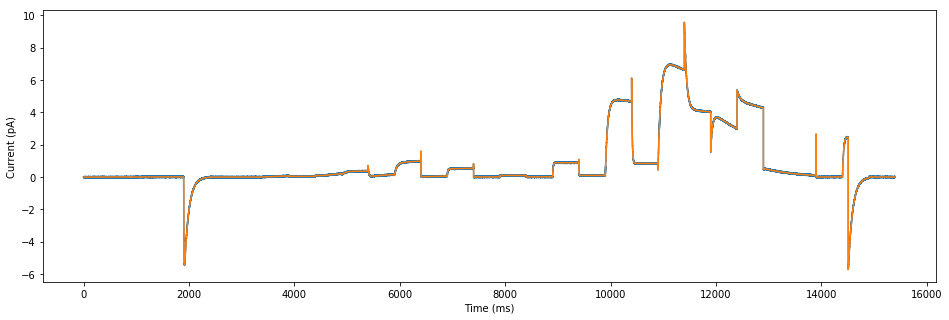

In [14]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.show()
plt.show()

And repeat, but this time using log-transforms on the a-type parameters:

In [15]:
# Run the optimisation
opt = pints.OptimisationController(
    transformed_error, q0, boundaries=transformed_boundaries)
opt.set_parallel(True)
q2, f2 = opt.run()

# De-transform the result
x2 = transform.to_model(q2)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     2351.708   0:00.2
1     20     2250.67    0:00.4
2     30     2033.186   0:00.6
3     40     1933.224   0:00.8
20    181    417.6016   0:03.6
40    300    9.902505   0:05.9
60    425    7.844145   0:08.3
80    566    7.255019   0:11.1
100   717    6.381506   0:14.5
120   837    5.512726   0:16.9
140   974    4.939528   0:19.6
160   1120   4.547312   0:22.3
180   1257   3.965162   0:24.8
200   1422   1.390341   0:27.5
220   1589   1.01719    0:30.2
240   1745   0.972      0:32.8
260   1907   0.962      0:35.7
280   2038   0.96       0:38.4
300   2171   0.95758    0:40.8
320   2312   0.953      0:43.2
340   2457   0.94       0:45.7
360   2634   0.931      0:48.6
380   2787   0.926304   0:51.3
400   2934   0.925      0:53.7
420   3106   0.92       0:56.6
440   3245   0.917      0:59.0
460   3392

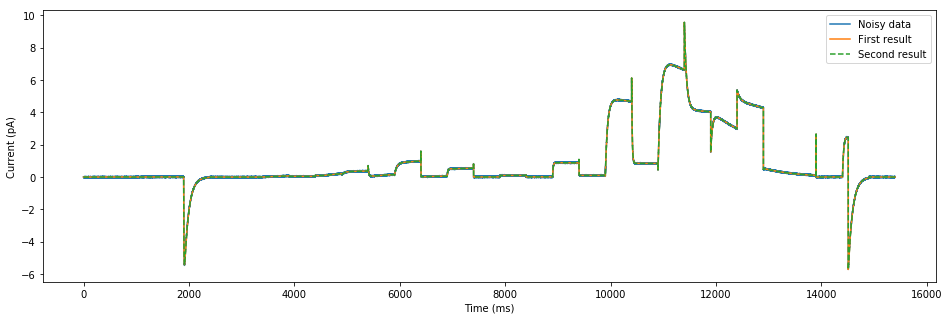

In [18]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.plot(times, problem.evaluate(x2), '--', label='Second result')
plt.legend()
plt.show()

While there's a fair amount of stochasticity involved in every re-run, there is a good chance that the results above show the same result obtained by both optimisations, but faster (and with a lower number of total evaluations) when using the log transforms.

## Summary

In this part of the tutorial we have

- Created an object that can transform between model and search space
- Created wrappers around a [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.ForwardModel) and [pints.Boundaries](https://pints.readthedocs.io/en/latest/boundaries.html#pints.Boundaries) object.
- Used these to run an optimisation in a transformed parameter space.

In the next part of the tutorial we will take a look at some of the problems associated with real patch-clamp data.